# Segmenting and Clustering Neighborhoods in Toronto

## Introduction

In this part of the project, I will use the Foursquare API to explore neighborhoods in Toronto. I will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. I then will use the *k*-means clustering algorithm to complete this task. Finally, I will use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters.

To begin with let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2p             |       h470a237_1         3.1 MB  conda-forge
    geopy-1.17.0               |             py_0          49 KB  conda-forge
    certifi-2018.11.29         |        py36_1000         145 KB  conda-forge
    conda-4.5.11               |        py36_1000         651 KB  conda-forge
    ca-certificates-2018.11.29 |       ha4d7672_0         143 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.1 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0            conda-forge
    geopy:           

<a id='item1'></a>

##  Retrieve and Explore Dataset

Neighborhood has a total of 11 boroughs and 103 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 11 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

In parts I and II of this project we have retrived, scarpe, wrangled the data. We will use the output of those two projects as our dataset. 

#### Load and explore the data

Next, let's load the data and then have a birds-eye view of the data to make sure everything is inorder

In [2]:
neighborhoods = pd.read_csv("Toronto_Data.csv",index_col=0)
neighborhoods.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


And make sure that the dataset has all 11 boroughs and 103 neighborhoods.

In [3]:
print('The dataframe has {} Boroughs and {} Neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 11 Boroughs and 103 Neighborhoods.


#### Use geopy library to get the latitude and longitude values of Toronto.

In [4]:
address = 'Toronto, TO'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [5]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only boroughs that contain the word Toronto. So let's slice the original dataframe and create a new dataframe of the Toronto data.

In [6]:
torontto_data = neighborhoods[neighborhoods['Borough'].str.contains('Toronto')].reset_index(drop=True)
torontto_data.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


Let's get the geographical coordinates of Manhattan.

In [7]:
address = 'Toronto, TO'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto are 43.653963, -79.387207.


As we did with all of Toronto, let's visualize Boroughs with the word Toronto in its name.

In [8]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(torontto_data['Latitude'], torontto_data['Longitude'], torontto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [9]:
CLIENT_ID = 'RNAMTYOPAUCQPDADV3AXODUUDBB2OCPB043YZQJBP4QOYTDD' # your Foursquare ID
CLIENT_SECRET = 'NHK12C5MYVURMATJKZGPJVELOQURCDYL2UW3XIM1Z0R5DCCT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RNAMTYOPAUCQPDADV3AXODUUDBB2OCPB043YZQJBP4QOYTDD
CLIENT_SECRET:NHK12C5MYVURMATJKZGPJVELOQURCDYL2UW3XIM1Z0R5DCCT


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [10]:
torontto_data.loc[0, 'Neighbourhood']

'Harbourfront,Regent Park'

Get the neighborhood's latitude and longitude values.

In [11]:
neighborhood_latitude = torontto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = torontto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = torontto_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Harbourfront,Regent Park are 43.6542599, -79.3606359.


#### Now, let's get the top 100 venues that are in Harbourfront (Regent Park), within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [12]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=RNAMTYOPAUCQPDADV3AXODUUDBB2OCPB043YZQJBP4QOYTDD&client_secret=NHK12C5MYVURMATJKZGPJVELOQURCDYL2UW3XIM1Z0R5DCCT&v=20180605&ll=43.6542599,-79.3606359&radius=500&limit=100'

Send the GET request and examine the resutls

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c035cbb1ed2192ca6d320e5'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 48,
  'suggestedBounds': {'ne': {'lat': 43.6587599045, 'lng': -79.3544279001486},
   'sw': {'lat': 43.6497598955, 'lng': -79.36684389985142}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'display',
 

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo YMCA,Gym / Fitness Center,43.653191,-79.357947
3,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149
4,Body Blitz Spa East,Spa,43.654735,-79.359874


And how many venues were returned by Foursquare?

In [16]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

48 venues were returned by Foursquare.


<a id='item2'></a>

##  Explore Neighborhoods in Toronto

#### Let's create a function to repeat the same process to all the neighborhoods in Toronto

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Extending the above function on each neighborhood and creating a new dataframe called *toronto_venues*.

In [18]:

toronto_venues = getNearbyVenues(names=torontto_data['Neighbourhood'],
                                   latitudes=torontto_data['Latitude'],
                                   longitudes=torontto_data['Longitude']
                                  )



Harbourfront,Regent Park
Ryerson,Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide,King,Richmond
Dovercourt Village,Dufferin
Harbourfront East,Toronto Islands,Union Station
Little Portugal,Trinity
The Danforth West,Riverdale
Design Exchange,Toronto Dominion Centre
Brockton,Exhibition Place,Parkdale Village
The Beaches West,India Bazaar
Commerce Court,Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North,Forest Hill West
High Park,The Junction South
North Toronto West
The Annex,North Midtown,Yorkville
Parkdale,Roncesvalles
Davisville
Harbord,University of Toronto
Runnymede,Swansea
Moore Park,Summerhill East
Chinatown,Grange Park,Kensington Market
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown,St. James Town
First Canadian Place,Underground city


## Let's check the size of the resulting dataframe

In [19]:
print(toronto_venues.shape)
toronto_venues.head()

(1698, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Harbourfront,Regent Park",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Harbourfront,Regent Park",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Harbourfront,Regent Park",43.65426,-79.360636,Cooper Koo YMCA,43.653191,-79.357947,Gym / Fitness Center
3,"Harbourfront,Regent Park",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,"Harbourfront,Regent Park",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


Let's check how many venues were returned for each neighborhood

In [20]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Berczy Park,54,54,54,54,54,54
"Brockton,Exhibition Place,Parkdale Village",21,21,21,21,21,21
Business reply mail Processing Centre969 Eastern,16,16,16,16,16,16
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",14,14,14,14,14,14
"Cabbagetown,St. James Town",50,50,50,50,50,50
Central Bay Street,80,80,80,80,80,80
"Chinatown,Grange Park,Kensington Market",99,99,99,99,99,99
Christie,16,16,16,16,16,16


#### Let's find out how many unique categories can be curated from all the returned venues

In [21]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 234 uniques categories.


In [22]:
Todata=pd.DataFrame({'count' :toronto_venues.groupby('Neighborhood').size()}).reset_index()
Todata.describe()

,count
count,38.000000
mean,44.684211
std,36.462573
min,3.000000
25%,16.000000
50%,35.000000
75%,83.000000
max,100.000000


In [23]:
Torn=toronto_venues[toronto_venues['Neighborhood']=='Adelaide,King,Richmond']
Torn.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
American Restaurant,4,4,4,4,4,4
Art Gallery,1,1,1,1,1,1
Art Museum,1,1,1,1,1,1
Asian Restaurant,2,2,2,2,2,2
Bakery,2,2,2,2,2,2
Bar,3,3,3,3,3,3
Bookstore,2,2,2,2,2,2
Brazilian Restaurant,1,1,1,1,1,1
Breakfast Spot,2,2,2,2,2,2


In [24]:
Torn1=toronto_venues[toronto_venues['Neighborhood']=='Berczy Park']
Torn1.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Art Gallery,1,1,1,1,1,1
Bagel Shop,1,1,1,1,1,1
Bakery,2,2,2,2,2,2
Basketball Stadium,1,1,1,1,1,1
Beach,1,1,1,1,1,1
Beer Bar,1,1,1,1,1,1
Belgian Restaurant,1,1,1,1,1,1
Bistro,1,1,1,1,1,1
Café,2,2,2,2,2,2


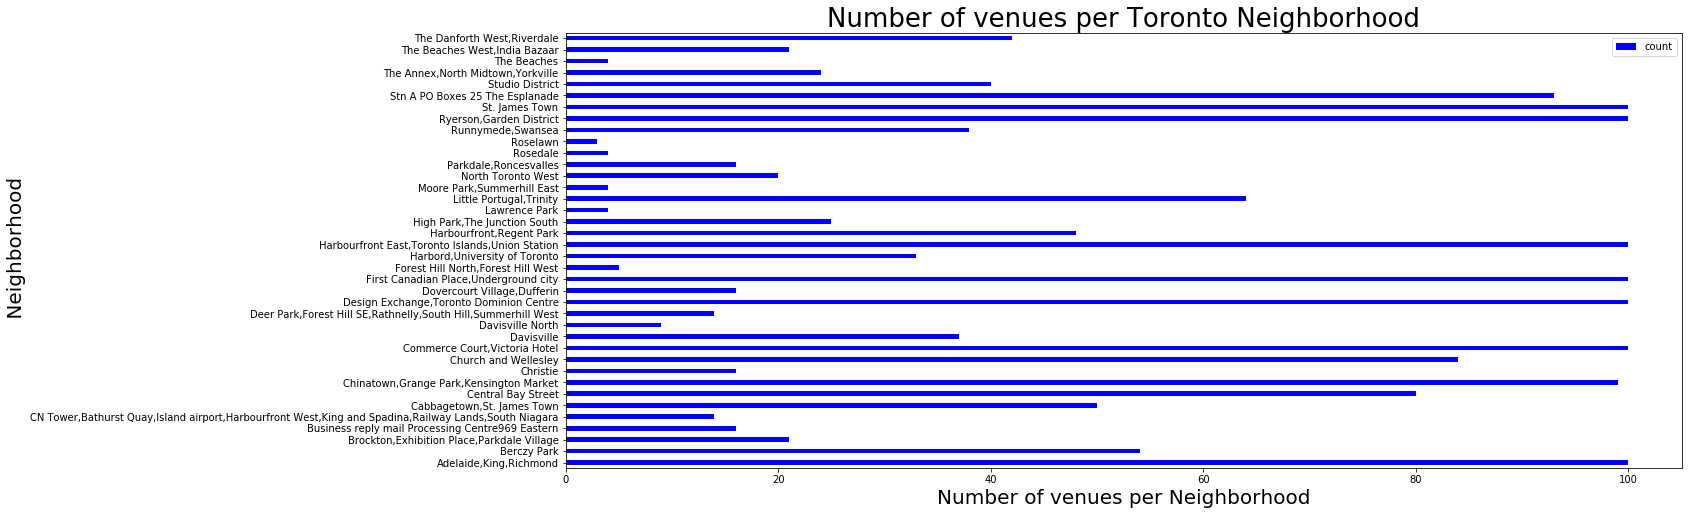

In [25]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
ax=Todata.set_index('Neighborhood')
ax.plot(kind='barh', figsize=(20, 8), width=0.4, color='blue')
plt.xlabel('Number of venues per Neighborhood',fontsize=20) # add to x-label to the plot
plt.ylabel(' Neighborhood',fontsize=20) # add y-label to the plot
plt.title('Number of venues per Toronto Neighborhood', fontsize=26) # add title to the plot
plt.savefig("bar.png")
plt.show()

In [26]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))


There are 234 uniques categories.


<a id='item3'></a>

##  Analyze Each Neighborhood

In [27]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Harbourfront,Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [28]:
toronto_onehot.shape

(1698, 234)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [29]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,0.000000,0.000000,0.010000,0.0100,0.000000,0.020000,0.0000,0.0000,0.000000,0.0000,0.000000,0.020000,0.000000,0.030000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.01,0.020000,0.000000,0.000000,0.01,0.020000,0.010000,0.00,0.0000,0.050000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.010000,0.070000,0.000000,0.000000,0.00,0.000000,0.0000,0.020000,0.000000,0.020000,0.000,0.000000,0.000000,0.000000,0.000000,0.010000,0.0100,0.000000,0.000000,0.000000,0.0000,0.000000,0.

#### Let's confirm the new size

In [30]:
toronto_grouped.shape

(38, 234)

In [31]:
neigh_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()

conditions = neigh_grouped[['Sushi Restaurant','Japanese Restaurant','Asian Restaurant']].sum(axis=1) > 1
neigh_sushi = neigh_grouped[conditions]


print(neigh_sushi.shape)
neigh_sushi.head(12)

(13, 234)


,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0,0,0,0,0,0,0,0,0,4,0,0,0,0,1,1,0,2,0,0,0,0,0,2,0,3,0,0,0,0,0,0,0,0,2,0,1,2,0,0,1,2,1,0,0,5,0,0,0,0,0,0,0,3,1,7,0,0,0,0,0,2,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,1,0,3,1,0,0,0,0,0,0,0,0,0,3,0,1,1,0,0,0,0,2,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1,0,0,1,0,3,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,4,0,0,2,0,0,0,0,0,0,0,0,4,1,0,0,0,1,0,0,0,1,0,0,1
6,Central Bay Street,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,4,0,1,0,2,0,0,0,1,0,12,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0

We have thus 13 neighborhoods that have at least one Sushi house, Japanese restaurant and/or Asian restaurant. Let us now further explore top venues of these neighborhoods

In [32]:
Sushi_places = neigh_sushi.drop(['Neighborhood'],axis=1,inplace=False)

Sushi_places=Sushi_places.sum(axis=0).sort_values(ascending=False)
Sushi_places.head(10)

Coffee Shop            96
Café                   58
Restaurant             39
Hotel                  33
Bar                    26
Pizza Place            24
Japanese Restaurant    24
Italian Restaurant     23
American Restaurant    19
Seafood Restaurant     17
dtype: int64

Let us now calculate the average Sushi place for each negihborhood

In [33]:
sushi_Japan_number = Sushi_places['Japanese Restaurant']
sushi_Asian_number = Sushi_places['Asian Restaurant']
sushi_place_number = Sushi_places['Sushi Restaurant']
average_sushi_per_neighbourhood = (sushi_Japan_number + sushi_Asian_number + sushi_place_number) / neigh_sushi.shape[0]
print("The average Sushi place neighbourhood is:", average_sushi_per_neighbourhood)

The average Sushi place neighbourhood is: 3.4615384615384617


As the average Sushi place neighbourhood is 3.5384615384615383, let us for practical reason round it to be 4. Next let us explore the number of Sushi places per neighborhood which are less than the average.


In [34]:
conditions = neigh_grouped[['Sushi Restaurant','Japanese Restaurant','Asian Restaurant']].sum(axis=1) < 4
neigh_target = neigh_grouped[conditions]

print("Size of the dataframe is", neigh_target.shape)
neigh_target.head(10)

Size of the dataframe is (35, 234)


,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
1,Berczy Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,1,3,4,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,"Brockton,Exhibition Place,Parkdale Village",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,2,0,1,0,0,0,0,1,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0

We can see that 34 neighborhoods have less than the average number of Sushi places per neighborhood. For the sake of convienence we now develop a dataframe only of relevant features, about the location, for our analysis.

In [35]:
toronto_venues.set_index('Neighborhood',inplace=True)
sushitarget = toronto_venues.loc[neigh_target['Neighborhood']]
sushitarget.reset_index(inplace=True)
print(sushitarget.columns.values)


['Neighborhood' 'Neighborhood Latitude' 'Neighborhood Longitude' 'Venue'
 'Venue Latitude' 'Venue Longitude' 'Venue Category']


In [36]:
sushitarget1 = sushitarget['Venue Category'].groupby([sushitarget['Neighborhood'],sushitarget['Neighborhood Latitude'],sushitarget['Neighborhood Longitude']]).apply(lambda x: ', '.join(x))
sushitarget2 = pd.DataFrame(sushitarget1)
print(sushitarget2.shape)
sushitarget2.head()

(35, 1)


,,,Venue Category
Neighborhood,Neighborhood Latitude,Neighborhood Longitude,
Berczy Park,43.644771,-79.373306,"Liquor Store, Steakhouse, Concert Hall, Museum..."
"Brockton,Exhibition Place,Parkdale Village",43.636847,-79.428191,"Gym, Coffee Shop, Bar, Caribbean Restaurant, C..."
Business reply mail Processing Centre969 Eastern,43.662744,-79.321558,"Brewery, Farmers Market, Comic Shop, Pizza Pla..."
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",43.628947,-79.394420,"Airport, Airport Lounge, Harbor / Marina, Airp..."
"Cabbagetown,St. James Town",43.667967,-79.367675,"Diner, Italian Restaurant, Indian Restaurant, ..."


In [37]:
popularlist = ['Café','Coffee Shop','Restaurant','Bar','Hotel','Pizza Place','Bakery']
for i in popularlist:
    sushitarget3 = sushitarget2[sushitarget2['Venue Category'].str.contains(i)]
print(sushitarget3.shape)
sushitarget3

(15, 1)


,,,Venue Category
Neighborhood,Neighborhood Latitude,Neighborhood Longitude,
Berczy Park,43.644771,-79.373306,"Liquor Store, Steakhouse, Concert Hall, Museum..."
"Cabbagetown,St. James Town",43.667967,-79.367675,"Diner, Italian Restaurant, Indian Restaurant, ..."
"Chinatown,Grange Park,Kensington Market",43.653206,-79.400049,"Mexican Restaurant, Arts & Crafts Store, Café,..."
"Commerce Court,Victoria Hotel",43.648198,-79.379817,"Restaurant, Gym, Gastropub, Café, Café, Gym / ..."
"Design Exchange,Toronto Dominion Centre",43.647177,-79.381576,"Restaurant, Gym, Hotel, Gastropub, Café, Baker..."
"Dovercourt Village,Dufferin",43.669005,-79.442259,"Bar, Middle Eastern Restaurant, Supermarket, G..."
"Harbord,University of Toronto",43.662696,-79.400049,"Japanese Restaurant, Restaurant, Italian Resta..."
"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752,"Neighborhood, Park, Lake, Salad Place, Sportin..."
"Harbourfront,Regent Park",43.654260,-79.360636,"Bakery, Coffee Shop, Gym / Fitness Center, Bre..."


In [38]:

sushitarget4=sushitarget3.reset_index(inplace=False)
sushitarget5=neigh_grouped.set_index('Neighborhood',inplace=False)
sushitarget6=sushitarget5.loc[sushitarget4['Neighborhood'],['Sushi Restaurant','Japanese Restaurant','Asian Restaurant']]
sushitarget6

,Sushi Restaurant,Japanese Restaurant,Asian Restaurant
Neighborhood,,,
Berczy Park,0,0,0
"Cabbagetown,St. James Town",0,1,0
"Chinatown,Grange Park,Kensington Market",0,1,0
"Commerce Court,Victoria Hotel",0,1,0
"Design Exchange,Toronto Dominion Centre",0,2,1
"Dovercourt Village,Dufferin",0,0,0
"Harbord,University of Toronto",1,2,0
"Harbourfront East,Toronto Islands,Union Station",1,1,0
"Harbourfront,Regent Park",0,0,1


In [39]:
sushitarget7 = sushitarget6.sum(axis=1).sort_values(ascending=True)
sushitarget7

Neighborhood
Berczy Park                                        0
Dovercourt Village,Dufferin                        0
High Park,The Junction South                       0
Studio District                                    0
Cabbagetown,St. James Town                         1
Chinatown,Grange Park,Kensington Market            1
Commerce Court,Victoria Hotel                      1
Harbourfront,Regent Park                           1
The Danforth West,Riverdale                        1
Harbourfront East,Toronto Islands,Union Station    2
Little Portugal,Trinity                            2
St. James Town                                     2
Stn A PO Boxes 25 The Esplanade                    2
Design Exchange,Toronto Dominion Centre            3
Harbord,University of Toronto                      3
dtype: int64

In [40]:
the_best_location = sushitarget7.index[0:5]
print("the top five location to open Shushi places is {} ".format(the_best_location))
sushitarget7a = sushitarget3.loc[the_best_location]

the top five location to open Shushi places is Index(['Berczy Park', 'Dovercourt Village,Dufferin',
       'High Park,The Junction South', 'Studio District',
       'Cabbagetown,St. James Town'],
      dtype='object', name='Neighborhood') 


In [41]:
sushitarget7a.reset_index(inplace=True)
sushitarget7b = sushitarget7a.iloc[0].values[0:2].tolist()
print("the best location to start a Sushi business is {} ".format(the_best_location))
print("the location is {}".format(sushitarget7b))

the best location to start a Sushi business is Index(['Berczy Park', 'Dovercourt Village,Dufferin',
       'High Park,The Junction South', 'Studio District',
       'Cabbagetown,St. James Town'],
      dtype='object', name='Neighborhood') 
the location is ['Berczy Park', 43.6447708]


#### Let's print each neighborhood along with the top 5 most common venues

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Steakhouse,American Restaurant,Thai Restaurant,Clothing Store,Hotel,Restaurant,Gym,Bar
1,Berczy Park,Coffee Shop,Restaurant,Cocktail Bar,Seafood Restaurant,Café,Farmers Market,Steakhouse,Bakery,Pub,Cheese Shop
2,"Brockton,Exhibition Place,Parkdale Village",Coffee Shop,Café,Breakfast Spot,Grocery Store,Italian Restaurant,Convenience Store,Pet Store,Gym,Climbing Gym,Caribbean Restaurant
3,Business reply mail Processing Centre969 Eastern,Yoga Studio,Auto Workshop,Garden Center,Garden,Light Rail Station,Fast Food Restaurant,Farmers Market,Comic Shop,Butcher,Restaurant
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Lounge,Airport Terminal,Airport Service,Harbor / Marina,Sculpture Garden,Boutique,Plane,Boat or Ferry,Airport Gate,Airport
5,"Cabbagetown,St. James Town",Coffee Shop,Restaurant,Pizza Place,Bakery,Indian Restaurant,Italian Restaurant,Pub,Café,Market,Chinese Restaurant
6,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Bubble Tea Shop,Bar,Burger Joint,Ice Cream Shop,Thai Restaurant,Salad Place
7,"Chinatown,Grange Park,Kensington Market",Café,Bar,Chinese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Bakery,Coffee Shop,Mexican Restaurant,Dumpling Restaurant,Gaming Cafe
8,Christie,Grocery Store,Café,Park,Diner,Italian Restaurant,Baby Store,Restaurant,Nightclub,Athletics & Sports,Coffee Shop
9,Church and Wellesley,Japanese Restaurant,Coffee Shop,Gay Bar,Sushi Restaurant,Restaurant,Burger Joint,Café,Pub,Men's Store,Mediterranean Restaurant


<a id='item4'></a>

##  Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [44]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [45]:
toronto_merged = torontto_data

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636,2,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Theater,Café,Mexican Restaurant,Chocolate Shop,Italian Restaurant
1,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937,2,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Japanese Restaurant,American Restaurant,Restaurant,Ramen Restaurant,Pizza Place
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Restaurant,Hotel,Cosmetics Shop,Gastropub,Park,Clothing Store,Cocktail Bar,Bakery
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Music Venue,Coffee Shop,Pub,Women's Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Coffee Shop,Restaurant,Cocktail Bar,Seafood Restaurant,Café,Farmers Market,Steakhouse,Bakery,Pub,Cheese Shop


Finally, let's visualize the resulting clusters

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
#savefig("map_clusters.png") 

map_clusters

<a id='item5'></a>

##  Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster. 

In [47]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(torontto_data['Latitude'], torontto_data['Longitude'], torontto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  

map_Toronto


In [48]:
from folium import plugins

# let's start again with a clean copy of the map of San Francisco
map_Toronto_neigh = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(map_Toronto_neigh)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(sushitarget['Neighborhood Latitude'], sushitarget['Neighborhood Longitude'], sushitarget['Neighborhood']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display map
map_Toronto_neigh